In [1]:
import xgboost as xgb
import numpy as np
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
import time

In [2]:
%%time
# Fetch dataset using sklearn
cov = fetch_covtype()
X = cov.data
y = cov.target

CPU times: user 496 ms, sys: 36 ms, total: 532 ms
Wall time: 534 ms


In [3]:
%%time
# Create 0.75/0.25 train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, train_size=0.75,
                                                    random_state=42)

CPU times: user 80 ms, sys: 48 ms, total: 128 ms
Wall time: 127 ms


In [4]:
%%time
# Convert input data from numpy to XGBoost format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

num_round = 10
maxdepth = 6
# base parameters
param = {'tree_method': 'gpu_hist',
         'grow_policy': 'depthwise',
         'max_depth': maxdepth,
         'random_state': 1234,
         'objective': 'multi:softmax', # Specify multiclass classification
         'num_class': 8, # Number of possible output classes
         'base_score': 0.5,
         'booster': 'gbtree',
         'colsample_bylevel': 1,
         'colsample_bytree': 1,
         'gamma': 0,
         'learning_rate': 0.1, 
         'max_delta_step': 0,
         'min_child_weight': 1,
         'missing': None,
         'n_estimators': 3,
         'scale_pos_weight': 1,
         'silent': True,
         'subsample': 1,
         'verbose': True
         }

CPU times: user 100 ms, sys: 72 ms, total: 172 ms
Wall time: 172 ms


In [5]:
%%time
# GPU HIST DEPTHWISE
param['tree_method'] = 'gpu_hist'
param['grow_policy'] = 'depthwise'
param['max_depth'] = maxdepth
param['max_leaves'] = 0
gpu_res = {} # Store accuracy result
tmp = time.time()
# Train model
xgb.train(param, dtrain, num_round, evals=[(dtest, 'test')], evals_result=gpu_res)
print("GPU Training Time: %s seconds" % (str(time.time() - tmp)))

[0]	test-merror:0.254817
[1]	test-merror:0.254494
[2]	test-merror:0.250067
[3]	test-merror:0.247244
[4]	test-merror:0.245028
[5]	test-merror:0.244071
[6]	test-merror:0.243754
[7]	test-merror:0.242666
[8]	test-merror:0.241578
[9]	test-merror:0.240773
GPU Training Time: 4.564764499664307 seconds
CPU times: user 23 s, sys: 840 ms, total: 23.9 s
Wall time: 4.56 s


In [6]:
%%time
# GPU HIST LOSSGUIDE
param['tree_method'] = 'gpu_hist'
param['grow_policy'] = 'lossguide'
param['max_depth'] = 0
param['max_leaves'] = np.power(2,maxdepth)
gpu_res = {} # Store accuracy result
tmp = time.time()
# Train model
xgb.train(param, dtrain, num_round, evals=[(dtest, 'test')], evals_result=gpu_res)
print("GPU Training Time: %s seconds" % (str(time.time() - tmp)))

[0]	test-merror:0.232346
[1]	test-merror:0.222763
[2]	test-merror:0.218832
[3]	test-merror:0.216333
[4]	test-merror:0.214357
[5]	test-merror:0.213132
[6]	test-merror:0.211059
[7]	test-merror:0.209407
[8]	test-merror:0.207576
[9]	test-merror:0.205517
GPU Training Time: 4.155354261398315 seconds
CPU times: user 24.4 s, sys: 572 ms, total: 25 s
Wall time: 4.16 s


In [7]:
%%time
# CPU HIST DEPTHWISE
param['tree_method'] = 'hist'
param['grow_policy'] = 'depthwise'
param['max_depth'] = maxdepth
param['max_leaves'] = 0
cpu_res = {} # Store accuracy result
tmp = time.time()
# Train model
xgb.train(param, dtrain, num_round, evals=[(dtest, 'test')], evals_result=cpu_res)
print("CPU Training Time: %s seconds" % (str(time.time() - tmp)))

[0]	test-merror:0.254831
[1]	test-merror:0.254349
[2]	test-merror:0.249716
[3]	test-merror:0.247313
[4]	test-merror:0.245028
[5]	test-merror:0.244546
[6]	test-merror:0.243245
[7]	test-merror:0.242067
[8]	test-merror:0.24111
[9]	test-merror:0.241138
CPU Training Time: 118.56474781036377 seconds
CPU times: user 52min 43s, sys: 5.99 s, total: 52min 49s
Wall time: 1min 58s


In [8]:
%%time
# CPU HIST LOSSGUIDE
param['tree_method'] = 'hist'
param['grow_policy'] = 'lossguide'
param['max_depth'] = 0
param['max_leaves'] = np.power(2,maxdepth)
cpu_res = {} # Store accuracy result
tmp = time.time()
# Train model
xgb.train(param, dtrain, num_round, evals=[(dtest, 'test')], evals_result=cpu_res)
print("CPU Training Time: %s seconds" % (str(time.time() - tmp)))

[0]	test-merror:0.230515
[1]	test-merror:0.222515
[2]	test-merror:0.218646
[3]	test-merror:0.21623
[4]	test-merror:0.213827
[5]	test-merror:0.21278
[6]	test-merror:0.210509
[7]	test-merror:0.208478
[8]	test-merror:0.206653
[9]	test-merror:0.204794
CPU Training Time: 137.94367122650146 seconds
CPU times: user 1h 1min 43s, sys: 6.6 s, total: 1h 1min 49s
Wall time: 2min 17s


In [9]:
# SKLEARN API XGBOOST PARAMETERS
kwargs = {'grow_policy': 'depthwise',
          'eval_metric': 'mlogloss',
          'num_class': 8,
          'objective': 'multi:softmax',
          'n_estimators': num_round,
          'tree_method': "gpu_hist",
          'grow_policy': 'depthwise',
          'max_depth': maxdepth,
          'random_state': 1234,
          'verbose': True}
eval_metric = 'mlogloss'

In [10]:
%%time
# SKLEARN GPU HIST DEPTHWISE
kwargs['tree_method'] = 'gpu_hist'
kwargs['grow_policy'] = "depthwise"
kwargs['max_depth'] = maxdepth
kwargs['max_leaves'] = 0
model = xgb.XGBClassifier(**kwargs)
model.fit(X=X_train, y=y_train, verbose=True, eval_set=[(X_test, y_test)], eval_metric=eval_metric)
print(model.get_params())

[0]	validation_0-mlogloss:1.75749
[1]	validation_0-mlogloss:1.61192
[2]	validation_0-mlogloss:1.49304
[3]	validation_0-mlogloss:1.39354
[4]	validation_0-mlogloss:1.30886
[5]	validation_0-mlogloss:1.23415
[6]	validation_0-mlogloss:1.16927
[7]	validation_0-mlogloss:1.11169
[8]	validation_0-mlogloss:1.0603
[9]	validation_0-mlogloss:1.01412
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 10, 'n_jobs': 1, 'nthread': None, 'objective': 'multi:softprob', 'random_state': 1234, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1, 'grow_policy': 'depthwise', 'eval_metric': 'mlogloss', 'num_class': 8, 'tree_method': 'gpu_hist', 'verbose': True, 'max_leaves': 0}
CPU times: user 4.38 s, sys: 508 ms, total: 4.88 s
Wall time: 4.9 s


In [11]:
%%time
# SKLEARN GPU HIST LOSSGUIDE
kwargs['tree_method'] = 'gpu_hist'
kwargs['grow_policy'] = "lossguide"
kwargs['max_depth'] = 0
kwargs['max_leaves'] = np.power(2,maxdepth)
model = xgb.XGBClassifier(**kwargs)
model.fit(X=X_train, y=y_train, verbose=True, eval_set=[(X_test, y_test)], eval_metric=eval_metric)
print(model.get_params())

[0]	validation_0-mlogloss:1.74524
[1]	validation_0-mlogloss:1.59113
[2]	validation_0-mlogloss:1.46651
[3]	validation_0-mlogloss:1.36286
[4]	validation_0-mlogloss:1.27329
[5]	validation_0-mlogloss:1.19495
[6]	validation_0-mlogloss:1.12665
[7]	validation_0-mlogloss:1.06653
[8]	validation_0-mlogloss:1.01276
[9]	validation_0-mlogloss:0.964595
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 0, 'min_child_weight': 1, 'missing': None, 'n_estimators': 10, 'n_jobs': 1, 'nthread': None, 'objective': 'multi:softprob', 'random_state': 1234, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1, 'grow_policy': 'lossguide', 'eval_metric': 'mlogloss', 'num_class': 8, 'tree_method': 'gpu_hist', 'verbose': True, 'max_leaves': 64}
CPU times: user 4.84 s, sys: 420 ms, total: 5.26 s
Wall time: 5.26 s


In [12]:
%%time
# SKLEARN CPU HIST DEPTHWISE
kwargs['tree_method'] = 'hist'
kwargs['grow_policy'] = "depthwise"
kwargs['max_depth'] = maxdepth
kwargs['max_leaves'] = 0
model = xgb.XGBClassifier(**kwargs)
model.fit(X=X_train, y=y_train, verbose=True, eval_set=[(X_test, y_test)], eval_metric=eval_metric)
print(model.get_params())

[0]	validation_0-mlogloss:1.7575
[1]	validation_0-mlogloss:1.61197
[2]	validation_0-mlogloss:1.49308
[3]	validation_0-mlogloss:1.39359
[4]	validation_0-mlogloss:1.3089
[5]	validation_0-mlogloss:1.23419
[6]	validation_0-mlogloss:1.1693
[7]	validation_0-mlogloss:1.11172
[8]	validation_0-mlogloss:1.06032
[9]	validation_0-mlogloss:1.01414
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': None, 'n_estimators': 10, 'n_jobs': 1, 'nthread': None, 'objective': 'multi:softprob', 'random_state': 1234, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1, 'grow_policy': 'depthwise', 'eval_metric': 'mlogloss', 'num_class': 8, 'tree_method': 'hist', 'verbose': True, 'max_leaves': 0}
CPU times: user 27.5 s, sys: 152 ms, total: 27.7 s
Wall time: 27.7 s


In [13]:
%%time
# SKLEARN CPU HIST LOSSGUIDE
kwargs['tree_method'] = 'hist'
kwargs['grow_policy'] = "lossguide"
kwargs['max_depth'] = 0
kwargs['max_leaves'] = np.power(2,maxdepth)
model = xgb.XGBClassifier(**kwargs)
model.fit(X=X_train, y=y_train, verbose=True, eval_set=[(X_test, y_test)], eval_metric=eval_metric)
print(model.get_params())

[0]	validation_0-mlogloss:1.74526
[1]	validation_0-mlogloss:1.59115
[2]	validation_0-mlogloss:1.46653
[3]	validation_0-mlogloss:1.36288
[4]	validation_0-mlogloss:1.2733
[5]	validation_0-mlogloss:1.19497
[6]	validation_0-mlogloss:1.12667
[7]	validation_0-mlogloss:1.06654
[8]	validation_0-mlogloss:1.01277
[9]	validation_0-mlogloss:0.964607
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 0, 'min_child_weight': 1, 'missing': None, 'n_estimators': 10, 'n_jobs': 1, 'nthread': None, 'objective': 'multi:softprob', 'random_state': 1234, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 1, 'grow_policy': 'lossguide', 'eval_metric': 'mlogloss', 'num_class': 8, 'tree_method': 'hist', 'verbose': True, 'max_leaves': 64}
CPU times: user 27.4 s, sys: 84 ms, total: 27.5 s
Wall time: 27.5 s


In [14]:
%%time
###############################################
#
# GPU DEMO of feature importance
#
###############################################
num_round_more = 200
maxdepth_more = 6
# SKLEARN GPU HIST LOSSGUIDE
kwargs['tree_method'] = 'gpu_hist'
kwargs['grow_policy'] = "lossguide"
kwargs['max_depth'] = 0
kwargs['max_leaves'] = np.power(2,maxdepth_more)
kwargs['n_estimators'] = num_round_more
model = xgb.XGBClassifier(**kwargs)
eval_set = [(X_train, y_train),(X_test, y_test)]
model.fit(X=X_train, y=y_train, verbose=True, eval_set=eval_set, eval_metric=eval_metric, early_stopping_rounds=20)
print("Number of trees for best model: %d" % model.best_ntree_limit)
print("Model parameters: %s" % str(model.get_params()))


[0]	validation_0-mlogloss:1.74432	validation_1-mlogloss:1.74524
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 20 rounds.
[1]	validation_0-mlogloss:1.58936	validation_1-mlogloss:1.59113
[2]	validation_0-mlogloss:1.46402	validation_1-mlogloss:1.46651
[3]	validation_0-mlogloss:1.35969	validation_1-mlogloss:1.36286
[4]	validation_0-mlogloss:1.26963	validation_1-mlogloss:1.27329
[5]	validation_0-mlogloss:1.19082	validation_1-mlogloss:1.19495
[6]	validation_0-mlogloss:1.12219	validation_1-mlogloss:1.12665
[7]	validation_0-mlogloss:1.0616	validation_1-mlogloss:1.06653
[8]	validation_0-mlogloss:1.00737	validation_1-mlogloss:1.01276
[9]	validation_0-mlogloss:0.958994	validation_1-mlogloss:0.964595
[10]	validation_0-mlogloss:0.915855	validation_1-mlogloss:0.921763
[11]	validation_0-mlogloss:0.876349	validation_1-mlogloss:0.882494
[12]	validation_0-mlogloss:0.840865	validation_1-mlogloss:

[121]	validation_0-mlogloss:0.290716	validation_1-mlogloss:0.308274
[122]	validation_0-mlogloss:0.289918	validation_1-mlogloss:0.307548
[123]	validation_0-mlogloss:0.288769	validation_1-mlogloss:0.306487
[124]	validation_0-mlogloss:0.288187	validation_1-mlogloss:0.305981
[125]	validation_0-mlogloss:0.287535	validation_1-mlogloss:0.305386
[126]	validation_0-mlogloss:0.286824	validation_1-mlogloss:0.304734
[127]	validation_0-mlogloss:0.286197	validation_1-mlogloss:0.304182
[128]	validation_0-mlogloss:0.285123	validation_1-mlogloss:0.303213
[129]	validation_0-mlogloss:0.284105	validation_1-mlogloss:0.302258
[130]	validation_0-mlogloss:0.283043	validation_1-mlogloss:0.301303
[131]	validation_0-mlogloss:0.28181	validation_1-mlogloss:0.300151
[132]	validation_0-mlogloss:0.281101	validation_1-mlogloss:0.2995
[133]	validation_0-mlogloss:0.280219	validation_1-mlogloss:0.298676
[134]	validation_0-mlogloss:0.279534	validation_1-mlogloss:0.298039
[135]	validation_0-mlogloss:0.278841	validation_1-m

Test Set Accuracy: 90.32%


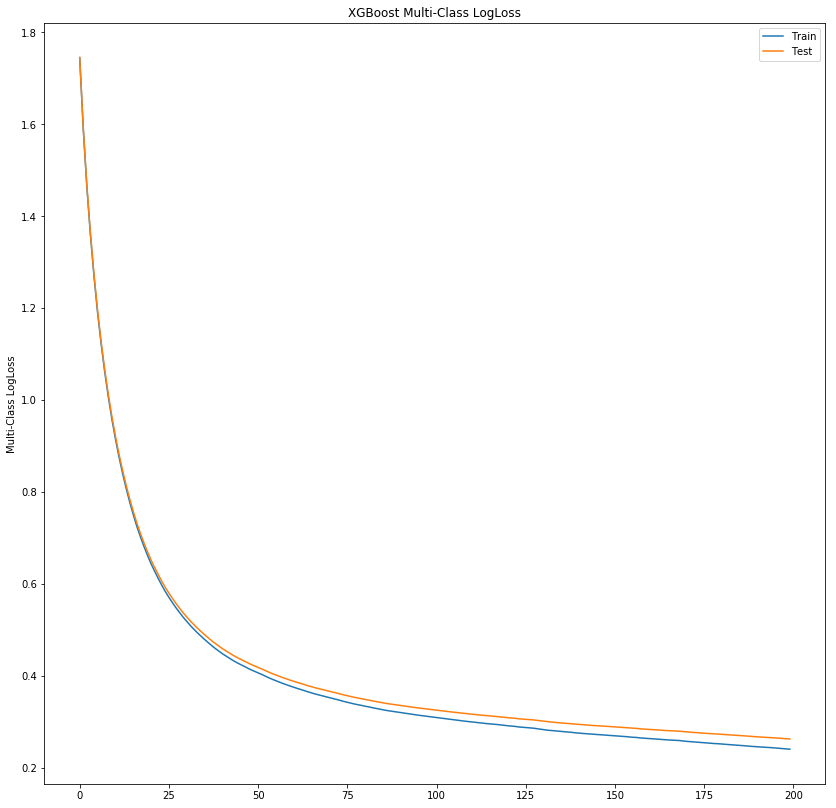

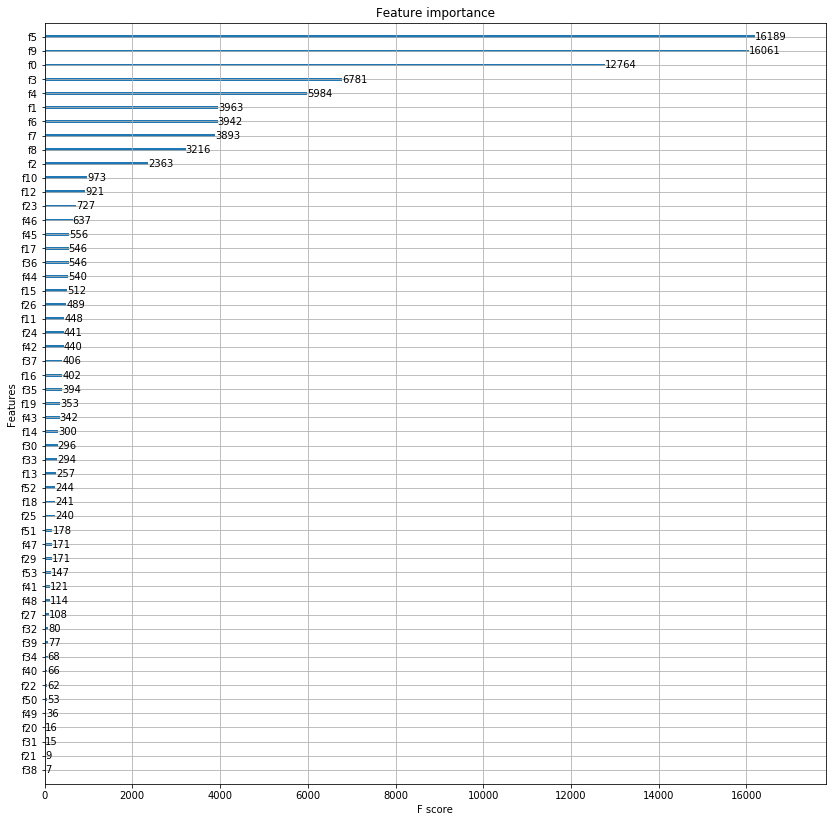

In [15]:
###############################################
#
# GPU DEMO of feature importance
#
###############################################
# Prediction
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predictions)
print("Test Set Accuracy: %.2f%%" % (accuracy * 100.0))

# Retrieve performance metrics
import matplotlib.pyplot as plt
results = model.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots(figsize=(14, 14))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('Multi-Class LogLoss')
plt.title('XGBoost Multi-Class LogLoss')
plt.show()

# plot feature importance using built-in function
from xgboost import plot_importance
# plot feature importance
fig, ax = plt.subplots(figsize=(14, 14))
plot_importance(model, ax=ax)
plt.show()

In [16]:
# new version using xgbfi-C++
def calc_varimp(context, model, columns, how_many, n_trees, from_depth, to_depth, **kwargs):
    t0 = time.time()
    booster = model._Booster
    booster.feature_names = columns

    max_xgbfi_tree_depth = 7
    max_xgbfi_tree_deepening = -1

    params = model.get_params()
    n_jobs = params['n_jobs']
    df_imp = booster.get_feature_interactions(to_depth,
                                              max_xgbfi_tree_depth,
                                              max_xgbfi_tree_deepening,
                                              n_trees,
                                              nthread=n_jobs)
    if df_imp.shape[0] == 0:
        df_imp = try_calc_varimp_gblinear(booster=booster, columns=columns, **kwargs)

    if df_imp.shape[0] == 0:
        df_imp['fi'] = columns
        df_imp['fi_depth'] = 0
        df_imp['gain'] = 1.0

    depth_from_to = (from_depth <= df_imp.fi_depth) & (df_imp.fi_depth <= to_depth)
    df_imp = df_imp[['fi', 'fi_depth', 'gain']].loc[depth_from_to].reset_index(drop=True)
    df_imp['fi_depth'] = df_imp['fi_depth'].astype(int)

    df_imp_feats = df_imp.loc[df_imp.fi_depth == 0, 'fi'].values
    missing_feats = np.setdiff1d(columns, df_imp_feats)
    if len(missing_feats) > 0 and from_depth == 0:
        df_missing_feats = pd.DataFrame()
        df_missing_feats['fi'] = missing_feats
        df_missing_feats['fi_depth'] = 0
        df_missing_feats['gain'] = 0.0
        df_imp = pd.concat((df_imp, df_missing_feats)) \
            .sort_values(by=['fi_depth', 'gain'], ascending=[True, False]) \
            .reset_index(drop=True)

    df_grp = df_imp.groupby('fi_depth')
    df_imp['gain'] = df_grp['gain'].transform(lambda x: (x / x.max()))
    df_imp = df_grp.head(how_many).reset_index(drop=True)
    df_imp.columns = ['Interaction', 'Depth', 'Gain']

    t1 = time.time()
    return df_imp


def try_calc_varimp_gblinear(booster, columns, **kwargs):
    df_imp = pd.DataFrame()
    dump = booster.get_dump()[0]
    if 'weight:' not in dump:
        return df_imp
    n_models = len(dump.split('\nweight:')[0].split('\n')[1:])
    imp = []
    for w in dump.split('\n')[2 + n_models:-1]:
        imp.append(abs(np.float("{:.6f}".format(float(w)))))
    imp = np.array(imp).reshape((-1, n_models)).mean(axis=1)
    df_imp['fi'] = columns
    df_imp['fi_depth'] = 0
    df_imp['gain'] = imp
    df_imp = df_imp.sort_values(by='gain', ascending=False).reset_index(drop=True)
    return df_imp

In [17]:
context=None
import pandas as pd
pd_X_train = pd.DataFrame(X_train)
booster = model._Booster
#booster.feature_names = [x for x in str(pd_X_train.columns.values)]
booster.feature_names = ["c"+str(x) for x in pd_X_train.columns.values]
kwargs = {}
# params: context, model, columns, N, n_trees, from_depth, to_depth, **kwargs)
Nimportance = 450
Ntrees = model.best_ntree_limit
from_depth = 0
to_depth = maxdepth
imp_features = calc_varimp(context, model, booster.feature_names, Nimportance, Ntrees, from_depth, to_depth, **kwargs)

In [18]:
imp_features[imp_features.Depth==0]

,Interaction,Depth,Gain
0,c0,0,1.000000
1,c5,0,0.085081
2,c9,0,0.077228
3,c3,0,0.055089
4,c10,0,0.037898
5,c7,0,0.026054
6,c17,0,0.023362
7,c12,0,0.022337
8,c15,0,0.021632
9,c45,0,0.019435


In [19]:
imp_features[imp_features.Depth==1]

,Interaction,Depth,Gain
54,c0|c0,1,1.000000
55,c0|c10,1,0.243162
56,c0|c15,1,0.109259
57,c0|c3,1,0.103762
58,c0|c17,1,0.097235
59,c0|c5,1,0.073638
60,c5|c9,1,0.067373
61,c0|c52,1,0.066638
62,c0|c12,1,0.042711
63,c0|c7,1,0.031482


In [20]:
%%time
dofinalcputest=1
if dofinalcputest==1:
    ###############################################
    #
    # CPU Model (compare time to GPU DEMO of feature importance) .  Run on Nvidia GTX 1080ti
    #
    ###############################################
    # SKLEARN GPU HIST LOSSGUIDE
    kwargs['tree_method'] = 'hist'
    kwargs['grow_policy'] = "lossguide"
    kwargs['max_depth'] = 0
    kwargs['max_leaves'] = np.power(2,maxdepth_more)
    kwargs['n_estimators'] = num_round_more
    model = xgb.XGBClassifier(**kwargs)
    eval_set = [(X_train, y_train),(X_test, y_test)]
    model.fit(X=X_train, y=y_train, verbose=True, eval_set=eval_set, eval_metric=eval_metric, early_stopping_rounds=20)
    print("Number of trees for best model: %d" % model.best_ntree_limit)
    print("Model parameters: %s" % str(model.get_params()))

[0]	validation_0-mlogloss:1.74432	validation_1-mlogloss:1.74526
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 20 rounds.
[1]	validation_0-mlogloss:1.58936	validation_1-mlogloss:1.59115
[2]	validation_0-mlogloss:1.46402	validation_1-mlogloss:1.46653
[3]	validation_0-mlogloss:1.35969	validation_1-mlogloss:1.36288
[4]	validation_0-mlogloss:1.26963	validation_1-mlogloss:1.2733
[5]	validation_0-mlogloss:1.19082	validation_1-mlogloss:1.19497
[6]	validation_0-mlogloss:1.12219	validation_1-mlogloss:1.12667
[7]	validation_0-mlogloss:1.0616	validation_1-mlogloss:1.06654
[8]	validation_0-mlogloss:1.00737	validation_1-mlogloss:1.01277
[9]	validation_0-mlogloss:0.958995	validation_1-mlogloss:0.964607
[10]	validation_0-mlogloss:0.915855	validation_1-mlogloss:0.921777
[11]	validation_0-mlogloss:0.87635	validation_1-mlogloss:0.882506
[12]	validation_0-mlogloss:0.840865	validation_1-mlogloss:0.

[121]	validation_0-mlogloss:0.288456	validation_1-mlogloss:0.305847
[122]	validation_0-mlogloss:0.287421	validation_1-mlogloss:0.304941
[123]	validation_0-mlogloss:0.286631	validation_1-mlogloss:0.304208
[124]	validation_0-mlogloss:0.285663	validation_1-mlogloss:0.303279
[125]	validation_0-mlogloss:0.284897	validation_1-mlogloss:0.302577
[126]	validation_0-mlogloss:0.284067	validation_1-mlogloss:0.301814
[127]	validation_0-mlogloss:0.283458	validation_1-mlogloss:0.301265
[128]	validation_0-mlogloss:0.282729	validation_1-mlogloss:0.300583
[129]	validation_0-mlogloss:0.281984	validation_1-mlogloss:0.299907
[130]	validation_0-mlogloss:0.281122	validation_1-mlogloss:0.299122
[131]	validation_0-mlogloss:0.28047	validation_1-mlogloss:0.298519
[132]	validation_0-mlogloss:0.27971	validation_1-mlogloss:0.297795
[133]	validation_0-mlogloss:0.279117	validation_1-mlogloss:0.297266
[134]	validation_0-mlogloss:0.278369	validation_1-mlogloss:0.29657
[135]	validation_0-mlogloss:0.277535	validation_1-m